
# 🔬 Auswertung & kritische Analyse der Vector-Suche (Methoden 1–4)

Dieses Notebook lädt die von `method_comparison.py` erzeugten Ergebnis-JSONs, bereitet sie auf und führt **kritische Auswertungen** durch:

In [1]:
# === Konfiguration (bei Bedarf anpassen) ===
from pathlib import Path
from typing import Dict, List, Literal

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from frozendict import frozendict
from matplotlib.figure import Figure
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde

SAVE_PGF = False
EVALUATION_METRICS = ["NDCG", "Recall", "MAP", "Precision"]
EVALUATION_AT_VALUES = [10, 75]
RESULTS_DIR = Path("results/all_query_metrics")
PGF_OUTPUT_DEF = Path("../src/code_output/4_metrics_eval")
STLYER_KWARGS = dict(
    position="!htbp",
    hrules=True,
    convert_css=True,
)

qwen_model_identifier = "DEFAULT_Qwen_Qwen3-Embedding-0.6B_cuda_76ac2760"
jinai_model_identifier = "DEFAULT_jinaai_jina-embeddings-v2-small-en_cuda_76ac2760"
MODEL_PATTERN_TO_LABEL = frozendict(
    {
        qwen_model_identifier: "Qwen 3",
        jinai_model_identifier: "Jina v2",
    }
)

MODEL_PATTERN_TO_FILE_PRA = frozendict(
    {
        qwen_model_identifier: PGF_OUTPUT_DEF / "qwen",
        jinai_model_identifier: PGF_OUTPUT_DEF / "jina_v2",
    }
)


SEED = 42  # Reproduzierbarkeit
METHODE_NUMBER_TO_LABEL = frozendict(
    {
        "1": "M1: Zusammengefügte Strings",
        "2": "M2: gewichtete Zusammengefügte Vektoren",
        "3": "M3: gewichtete Distanz basierte Fusion",
        "4": "M4: Nur Title Vektor",
    }
)

METHODE_NUMBER_TO_MAIN_COLOR = frozendict(
    {
        "1": "#D1E5F5",  # Pastellblau
        "2": "#FCE1D1",  # Zartes Apricot
        "3": "#D1F0EC",  # Helles Minzgrün
        "4": "#E3DDF2",  # Helles Lavendel
    }
)

SCOPE_TO_LABEL = frozendict(
    {
        "candidates": "Kandidaten-Suche",
        "catalog": "Katalog-Suche",
    }
)


def change_plot_settings(mode: str):
    if mode == "pgf":
        matplotlib.use("pgf")
        matplotlib.rcParams.update(
            {
                "pgf.texsystem": "xelatex",
                "font.family": "serif",
                "text.usetex": True,
                "pgf.rcfonts": False,
            }
        )
    elif mode == "show":
        matplotlib.use("agg")
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    else:
        raise ValueError(f"Unbekannter Modus für Plot-Einstellungen: {mode}")


def show_or_safe_fig(out: Path, fig: Figure, save_pgf: bool = SAVE_PGF):
    if save_pgf:
        change_plot_settings("pgf")
        fig.savefig(out, bbox_inches="tight")
        plt.close(fig)
        change_plot_settings("show")
    plt.show()


def get_path(model_pattern: str, file_sufix: str) -> Path:
    out = MODEL_PATTERN_TO_FILE_PRA[model_pattern] / file_sufix.lower()
    out.parent.mkdir(parents=True, exist_ok=True)
    print(f"Path will be {out}")
    return out


def extract_label_from_out_path(out: Path):
    generated_label = "tab:" + out.parent.name + "_" + out.name.replace(".tex", "")
    print(f"Generated label: {generated_label}")
    return generated_label


def load_metric_results(base_dir: Path) -> dict[str, dict[str, pd.DataFrame]]:
    #  BASE_DIR/candidates|catalog/METHODNUMBER.csv.gz
    out = {}
    for scope in ["candidates", "catalog"]:
        scope_dir = base_dir / scope
        friendly_scope = SCOPE_TO_LABEL[scope]
        if not scope_dir.exists():
            raise FileNotFoundError(f"Scope-Verzeichnis nicht gefunden: {scope_dir}")
        for mnum in METHODE_NUMBER_TO_LABEL.keys():
            fpath = scope_dir / f"{mnum}.csv.gz"
            if fpath.exists():
                dfm = pd.read_csv(fpath, index_col=0, compression="gzip")
                dfm.index.name = "qid"
                out.setdefault(friendly_scope, {})[mnum] = dfm
            else:
                raise FileNotFoundError(f"Datei nicht gefunden: {fpath}")
    return out

In [3]:
raw_results: dict[str, dict[str, dict[str, pd.DataFrame]]] = (
    {}
)  # model_pattern -> scope ["candidates"/"catalog"] -> method_number ["1"/"2"/"3"/"4"] -> DataFrame
for model_pattern in MODEL_PATTERN_TO_LABEL.keys():
    raw_results[model_pattern] = load_metric_results(RESULTS_DIR / model_pattern)

# 1 – Verteilungsanalyse der Metriken pro Model & Methode

Path will be ../src/code_output/4_metrics_eval/qwen/split_violin_ndcg10_75.pgf


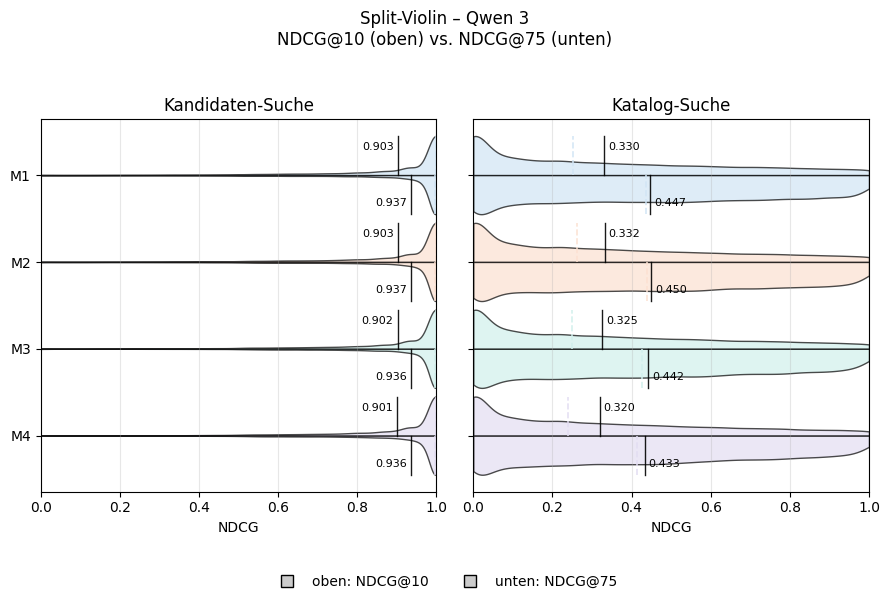

Path will be ../src/code_output/4_metrics_eval/qwen/split_violin_recall10_75.pgf


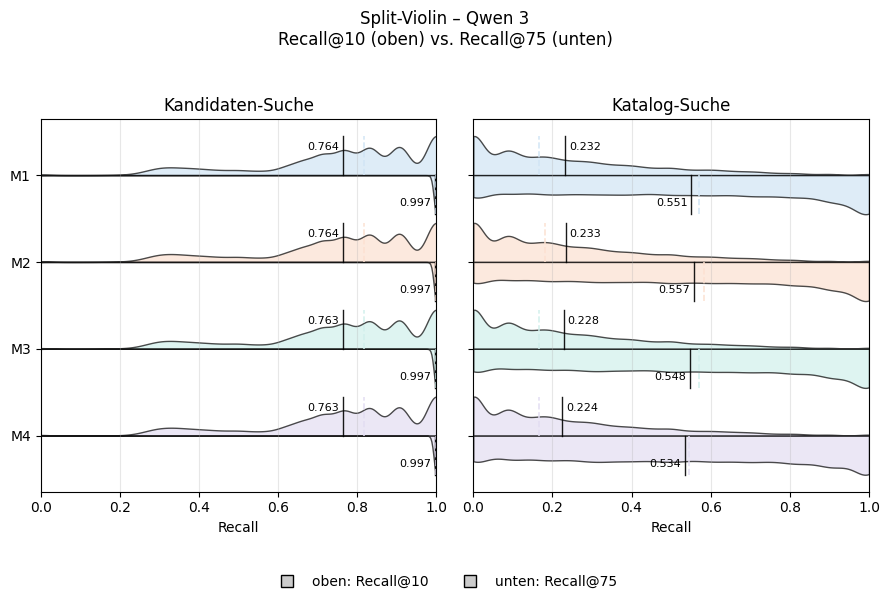

Path will be ../src/code_output/4_metrics_eval/qwen/split_violin_map10_75.pgf


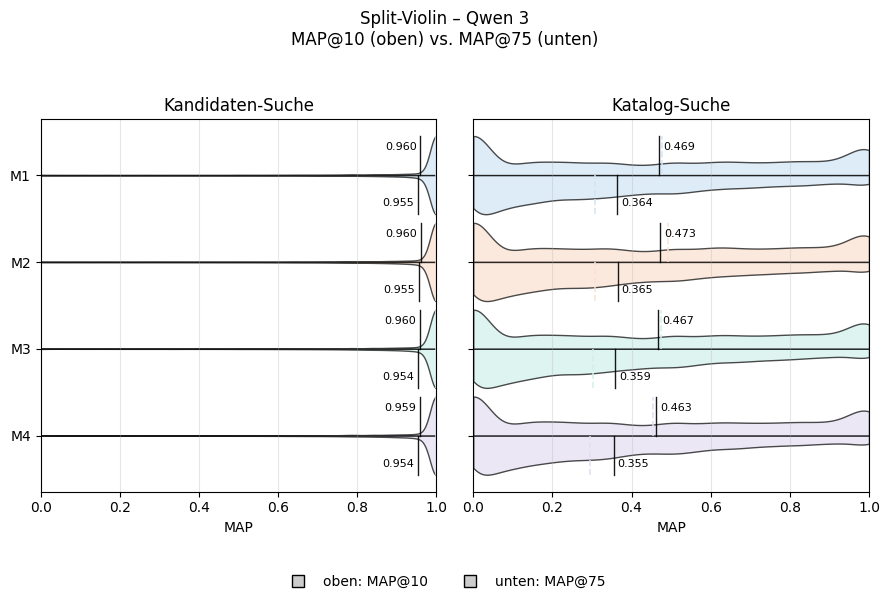

Path will be ../src/code_output/4_metrics_eval/qwen/split_violin_precision10_75.pgf


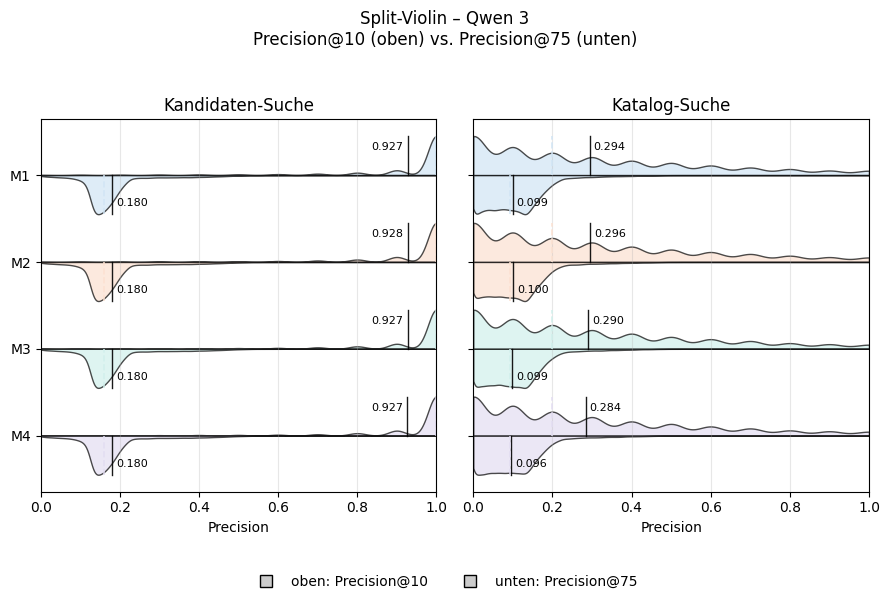

Path will be ../src/code_output/4_metrics_eval/jina_v2/split_violin_ndcg10_75.pgf


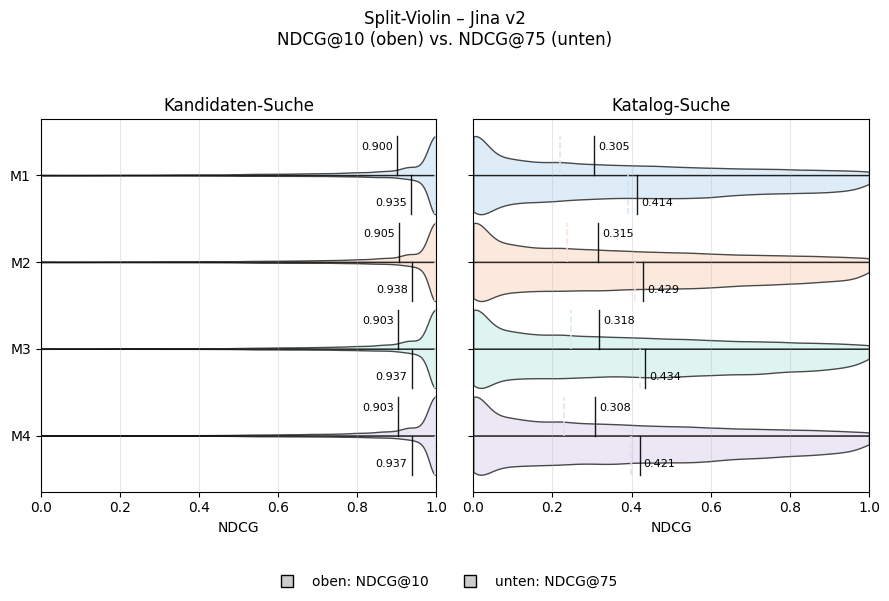

Path will be ../src/code_output/4_metrics_eval/jina_v2/split_violin_recall10_75.pgf


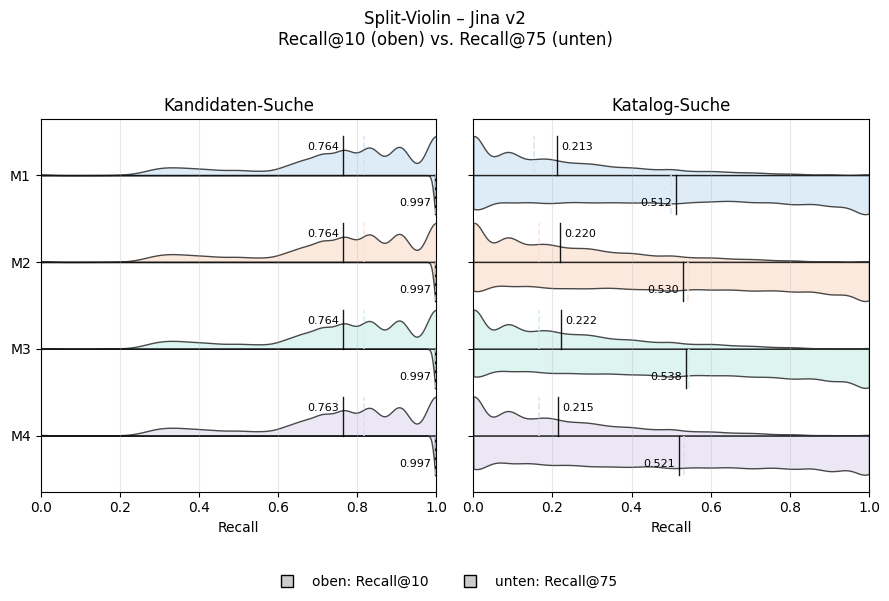

Path will be ../src/code_output/4_metrics_eval/jina_v2/split_violin_map10_75.pgf


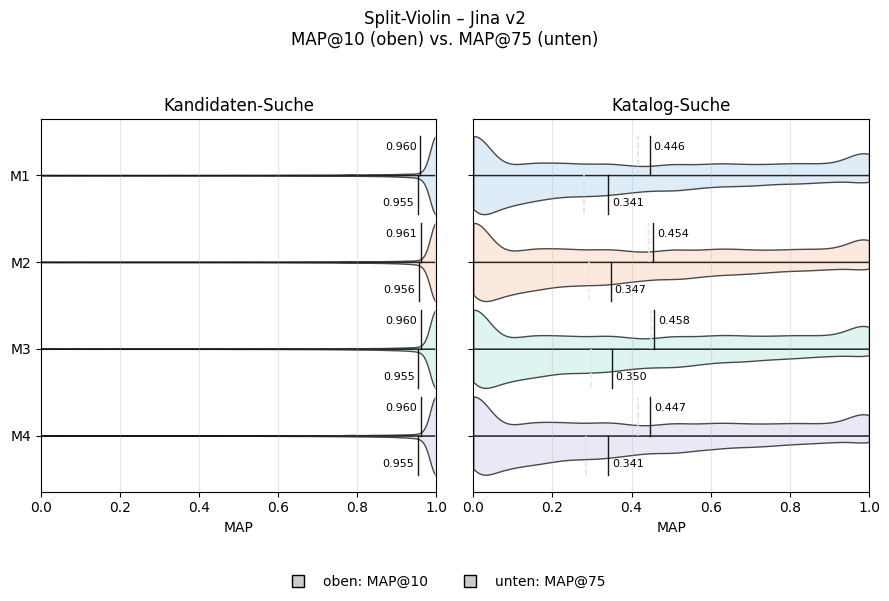

Path will be ../src/code_output/4_metrics_eval/jina_v2/split_violin_precision10_75.pgf


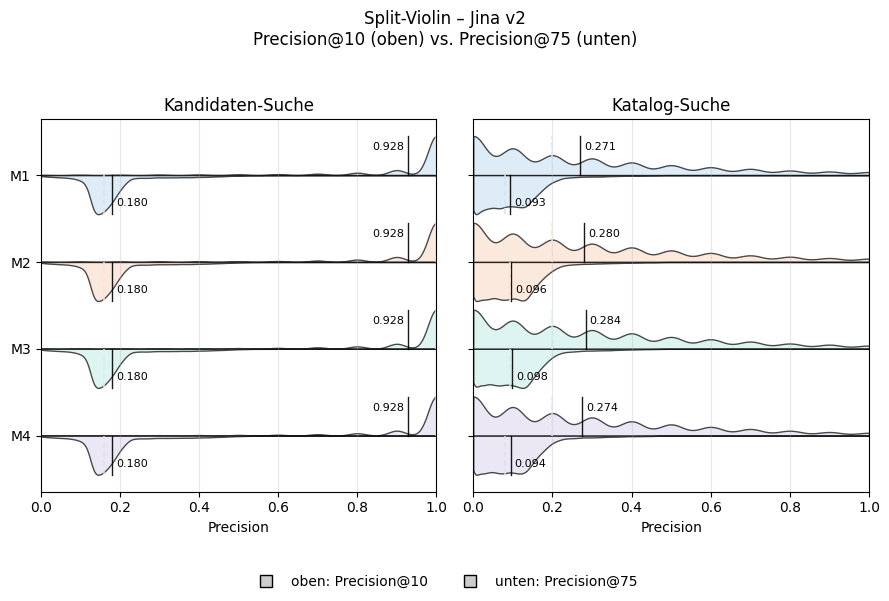

In [4]:
def _half_violin(
    ax: plt.Axes,
    data: np.ndarray,
    pos: float,
    side: Literal["top", "bottom"],
    color: str,
    bw_method: str | float = "scott",
    alpha: float = 0.7,
) -> None:
    """Draw a half violin for given data at position `pos`."""
    data = np.asarray(data, dtype=float)
    data = data[np.isfinite(data)]

    kde = gaussian_kde(data, bw_method=bw_method)
    xs = np.linspace(0.0, 1.0, 400)
    dens = kde(xs)
    dens = dens / dens.max() * 0.45  # scale width

    if side == "top":
        ax.fill_between(
            xs,
            pos,
            pos + dens,
            color=color,
            alpha=alpha,
            linewidth=1,
            edgecolor="black",
        )
    else:  # "bottom"
        ax.fill_between(
            xs,
            pos,
            pos - dens,
            color=color,
            alpha=alpha,
            linewidth=1,
            edgecolor="black",
        )


def _draw_center_lines(
    ax: plt.Axes,
    vals: np.ndarray,
    pos: float,
    side: Literal["top", "bottom"],
    color: str,
) -> None:
    """Draw mean (black) and median (colored) line for one half (top/bottom) and annotate mean."""
    vals = np.asarray(vals, dtype=float)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return

    mean_v = float(np.mean(vals))
    med_v = float(np.median(vals))

    center_distance = 0.45
    text_position_factor = 2.4
    if side == "top":
        y_low, y_high = pos, pos + center_distance
        text_y = (
            y_high - center_distance / text_position_factor
        )  # leicht unterhalb der Linie
        va = "bottom"
    else:  # "bottom"
        y_low, y_high = pos - center_distance, pos
        text_y = (
            y_low + center_distance / text_position_factor
        )  # leicht oberhalb der Linie
        va = "top"

    # Mean (schwarze Linie)
    ax.plot(
        [mean_v, mean_v],
        [y_low, y_high],
        color="black",
        lw=1,
        alpha=0.9,
    )

    # Median (farbige gestrichelte Linie)
    ax.plot(
        [med_v, med_v],
        [y_low, y_high],
        color=color,
        lw=1.2,
        ls="--",
        alpha=0.9,
    )

    # Mean-Text (z.B. 0.743)
    text_offset_x = 0.01
    ax.text(
        mean_v + (text_offset_x if mean_v < 0.5 else -text_offset_x),
        text_y,
        f"{mean_v:.3f}",
        ha="left" if mean_v < 0.5 else "right",
        va=va,
        fontsize=8,
    )


def plot_split_violin_ndcg(
    model_pattern: str,
    model_results: dict[str, dict[str, pd.DataFrame]],
    eval_metric: str,
) -> None:
    model_label = MODEL_PATTERN_TO_LABEL[model_pattern]
    v1 = EVALUATION_AT_VALUES[0]
    v2 = EVALUATION_AT_VALUES[-1]

    fig, axes = plt.subplots(1, 2, figsize=(9, 6), sharey=True)

    n_methods = len(METHODE_NUMBER_TO_MAIN_COLOR)
    for ax, (scope, method_dfs) in zip(axes, model_results.items()):
        ax.set_yticks(range(1, n_methods + 1))
        ax.set_yticklabels(
            [
                METHODE_NUMBER_TO_LABEL[m].split(":")[0]
                for m in METHODE_NUMBER_TO_MAIN_COLOR
            ][::-1],
            ha="right",
        )
        for mnum, color in METHODE_NUMBER_TO_MAIN_COLOR.items():
            # pos ist die y-Position der Methode e.g von unten nach oben -
            i = n_methods - int(mnum) + 1  # daher methode 4 ganz unten
            df = method_dfs[mnum]
            vals10 = df[f"{eval_metric}@{v1}"]
            vals40 = df[f"{eval_metric}@{v2}"]
            v10 = vals10.dropna().to_numpy(dtype=float)
            v40 = vals40.dropna().to_numpy(dtype=float)
            for val, side in zip([v10, v40], ["top", "bottom"]):
                _half_violin(ax, val, pos=i, side=side, color=color)
                _draw_center_lines(ax, val, pos=i, side=side, color=color)

        ax.set_xlim(0, 1)
        ax.set_xlabel(f"{eval_metric}")
        ax.set_title(f"{scope}")
        ax.grid(axis="x", alpha=0.3)

    top_patch = mlines.Line2D(
        [],
        [],
        color="black",
        lw=0,
        marker="s",
        markersize=8,
        label=f"oben: {eval_metric}@{v1}",
        markerfacecolor="#cccccc",
    )
    bot_patch = mlines.Line2D(
        [],
        [],
        color="black",
        lw=0,
        marker="s",
        markersize=8,
        label=f"unten: {eval_metric}@{v2}",
        markerfacecolor="#cccccc",
    )
    fig.legend(
        handles=[top_patch, bot_patch], loc="lower center", ncols=2, frameon=False
    )
    title = f"Split-Violin – {model_label}\n{eval_metric}@{v1} (oben) vs. {eval_metric}@{v2} (unten)"
    if not SAVE_PGF:
        fig.suptitle(title)
    else:
        print(title)
    fig.tight_layout(rect=(0, 0.08, 1, 0.95))

    out = get_path(model_pattern, f"split_violin_{eval_metric}{v1}_{v2}.pgf")
    show_or_safe_fig(out, fig)


for model_pattern, model_results in raw_results.items():
    for eval_metric in EVALUATION_METRICS:
        plot_split_violin_ndcg(
            model_pattern=model_pattern,
            model_results=model_results,
            eval_metric=eval_metric,
        )

In [5]:
import re


def convert_to_side_table(latex_str: str) -> str:
    # find  col index between \toprule and \midrule
    old_string_index = re.search(r"\\toprule(.*?)\\\\", latex_str, re.DOTALL).group(1)
    string_index = old_string_index[:]
    helper = string_index.split("&")
    for s in helper[1:]:
        string_index = string_index.replace(s, f"\\rotatebox{{90}}{{{s}}}")
    latex_str = latex_str.replace(old_string_index, string_index)

    # KORRIGIERT: LaTeX-Anpassungen für eine bessere Darstellung.
    latex_str = latex_str.replace("\\begin{table}", "\\begin{sidewaystable}")
    latex_str = latex_str.replace("\\end{table}", "\\end{sidewaystable}")
    latex_str = latex_str.replace(
        "\\begin{tabular}", "\\resizebox{\\textwidth}{!}{\\begin{tabular}"
    )
    latex_str = latex_str.replace("\\end{tabular}", "\\end{tabular}}")
    return latex_str


def summarize_ndcg_distributions(
    model_pattern: str,
    model_results: dict[str, dict[str, pd.DataFrame]],
    eval_metric: str,
) -> None:
    """
    (MultiIndex: scope, methode, metric) und zeigt sie an.
    Optional wird je Modell eine .tex-Datei geschrieben.
    """

    rows: list[pd.Series] = []
    index_tuples: list[tuple[str, str, str]] = []

    for scope, method_dfs in model_results.items():  # z.B. "catalog", "candidates"
        for mnum, df in method_dfs.items():
            for metric in EVALUATION_AT_VALUES:
                desc = df[
                    f"{eval_metric}@{metric}"
                ].describe()  # count, mean, std, min, 25%, 50%, 75%, max
                rows.append(desc)
                index_tuples.append((scope, metric, mnum))

    summary_df = pd.DataFrame(
        rows,
        index=pd.MultiIndex.from_tuples(
            index_tuples,
            names=["Scope", eval_metric, "method"],
        ),
    ).sort_index()
    # now style for better display
    styled = summary_df.style.format("{:.4f}").set_caption(
        f"Verteilungszusammenfassung {eval_metric} – Modell: {MODEL_PATTERN_TO_LABEL[model_pattern]}"
    )
    styled = styled.format("{:.0f}", subset=["count"])

    # background color for method rows
    def highlight_method_rows(row):
        method = row.name[2]
        color = METHODE_NUMBER_TO_MAIN_COLOR[method]
        # with transparency
        return [f"background-color: {color}"] * len(row)

    styled = styled.apply(highlight_method_rows, axis=1)
    file_name = f"{eval_metric.lower()}_describe"
    out = get_path(model_pattern, f"{file_name}.tex")
    label = extract_label_from_out_path(out)
    if SAVE_PGF:
        latex_str = styled.to_latex(
            caption=f"Verteilungszusammenfassung {eval_metric}– Modell: {MODEL_PATTERN_TO_LABEL[model_pattern]}",
            label=label,
            **STLYER_KWARGS,
            column_format="|"
            + "r|"
            * (
                len(summary_df.reset_index().columns)
            ),  # Spaltenindex für bessere Lesbarkeit
        ).replace("%", r"\%")
        latex_str = convert_to_side_table(latex_str)
        out.write_text(latex_str)
    display(styled)


for model_pattern, model_results in raw_results.items():
    for eval_metric in EVALUATION_METRICS:
        summarize_ndcg_distributions(
            model_pattern=model_pattern,
            model_results=model_results,
            eval_metric=eval_metric,
        )

Path will be ../src/code_output/4_metrics_eval/qwen/ndcg_describe.tex
Generated label: tab:qwen_ndcg_describe


Path will be ../src/code_output/4_metrics_eval/qwen/recall_describe.tex
Generated label: tab:qwen_recall_describe


Path will be ../src/code_output/4_metrics_eval/qwen/map_describe.tex
Generated label: tab:qwen_map_describe


Path will be ../src/code_output/4_metrics_eval/qwen/precision_describe.tex
Generated label: tab:qwen_precision_describe


Path will be ../src/code_output/4_metrics_eval/jina_v2/ndcg_describe.tex
Generated label: tab:jina_v2_ndcg_describe


Path will be ../src/code_output/4_metrics_eval/jina_v2/recall_describe.tex
Generated label: tab:jina_v2_recall_describe


Path will be ../src/code_output/4_metrics_eval/jina_v2/map_describe.tex
Generated label: tab:jina_v2_map_describe


Path will be ../src/code_output/4_metrics_eval/jina_v2/precision_describe.tex
Generated label: tab:jina_v2_precision_describe


In [6]:
def paired_permutation_test(
    a: np.ndarray, b: np.ndarray, num_permutations: int = 10000
) -> float:
    """Compute a paired two-sided permutation test p-value."""
    diff = a - b
    observed = np.mean(diff)
    count = 0
    np.random.seed(SEED)
    for _ in range(num_permutations):
        signs = np.random.choice([1, -1], size=len(diff))
        permuted = np.mean(diff * signs)
        if abs(permuted) >= abs(observed):
            count += 1
    return count / num_permutations


def cohen_dz(a: np.ndarray, b: np.ndarray) -> float:
    """Compute Cohen's dz for paired samples."""
    diff = a - b
    sd = np.std(diff, ddof=1)
    if sd == 0:
        return 0.0
    return np.mean(diff) / sd


def compute_significance_table(
    metrics: Dict[str, np.ndarray], num_permutations: int
) -> pd.DataFrame:
    """
    Compute pairwise significance tests for all methods.

    Parameters
    ----------
    metrics:
        Dict mapping method name -> 1D numpy array of metric values (paired across methods).
    num_permutations:
        Number of permutations for the permutation test.

    Returns
    -------
    pd.DataFrame
        Table with p-values, Cohen's dz and qualitative interpretation.
    """
    methods = list(metrics.keys())
    rows = []

    for i in range(len(methods)):
        for j in range(i + 1, len(methods)):
            m1, m2 = methods[i], methods[j]
            a, b = metrics[m1], metrics[m2]
            p = paired_permutation_test(a, b, num_permutations=num_permutations)
            d = cohen_dz(a, b)
            is_significant = p < 0.05
            match abs(d):
                case x if x >= 0.8:
                    eff = "Groß"
                case x if x >= 0.5:
                    eff = "Mittel"
                case x if x >= 0.2:
                    eff = "Klein"
                case _:
                    eff = "Vernachlässigbar"
            rows.append(
                {
                    "Methode A": m1,
                    "Methode B": m2,
                    "p-Wert": p,
                    "cohen_dz": d,
                    "Signifikant": is_significant,
                    "Effekt": eff,
                }
            )
    return pd.DataFrame(rows)


method_mectric_significance_results: dict[str, dict[str, pd.DataFrame]] = (
    {}
)  # model_pattern -> scope -> significance DataFrame
for model_pattern, model_results in raw_results.items():
    method_mectric_significance_results[model_pattern] = {}
    for scope, method_dfs in model_results.items():
        # Prepare metrics dict
        method_mectric_significance_results[model_pattern][scope] = helper = {}
        for metric in EVALUATION_METRICS:
            metrics_dict = {}
            for at in EVALUATION_AT_VALUES:
                metrics_of_interest = f"{metric}@{at}"
                for mnum, df in method_dfs.items():
                    vals = df[metrics_of_interest].dropna().to_numpy(dtype=float)
                    metrics_dict[METHODE_NUMBER_TO_LABEL[mnum]] = vals
                significance_df = compute_significance_table(
                    metrics_dict, num_permutations=10000
                )
                helper[metrics_of_interest] = significance_df

In [7]:
for model_pattern, scope_dfs in method_mectric_significance_results.items():
    model_label = MODEL_PATTERN_TO_LABEL[model_pattern]
    for scope, metric_dfs in scope_dfs.items():
        model_dfs = []
        for metric, sig_df in metric_dfs.items():
            df_new = sig_df.copy()
            df_new["Metrik"] = metric
            model_dfs.append(df_new)
        full_df = pd.concat(model_dfs, ignore_index=True)
        for col in [
            "Methode A",
            "Methode B",
        ]:
            full_df[col] = full_df[col].map(lambda x: x.split(":")[0])
        for col in ["p-Wert", "cohen_dz"]:
            full_df[col] = full_df[col].map(lambda x: round(x, 3))
        full_df.set_index(
            [
                "Methode A",
                "Methode B",
                "Metrik",
            ],
            inplace=True,
        )

        full_df.sort_index(inplace=True)
        if SAVE_PGF:
            full_df.columns = [
                x if x != "cohen_dz" else r"$\text{cohen}_\text{dz}$"
                for x in full_df.columns
            ]
        print(full_df.columns)

        title = f"Paarweise Signifikanztests – Modell: {model_label} – alle Metriken und Scopes"
        styled = full_df.style.set_caption(title)

        # mark cell red if significant
        def highlight_significant(row):
            if row["Signifikant"] and row["Effekt"] != "Vernachlässigbar":
                return ["background-color: #FFDDDD"] * len(row)
            return [""] * len(row)

        styled = styled.apply(highlight_significant, axis=1)
        file_name = f"significance_{scope}"
        out = get_path(model_pattern, f"{file_name}.tex")
        label = extract_label_from_out_path(out)
        if SAVE_PGF:

            styled.to_latex(buf=out, caption=title, label=label, **STLYER_KWARGS)
        display(styled)
        # check for signifikant  and effekt
        df_sig = full_df.loc[full_df["Effekt"] != "Vernachlässigbar"]
        if not df_sig.empty:
            file_name = file_name + "_effect"
            out = get_path(model_pattern, f"{file_name}.tex")
            label = extract_label_from_out_path(out)
            if SAVE_PGF:
                df_sig.style.to_latex(
                    buf=out,
                    caption=title + " -  mit Effekt",
                    label=label,
                    **STLYER_KWARGS,
                )
            display(df_sig.style)

Index(['p-Wert', 'cohen_dz', 'Signifikant', 'Effekt'], dtype='object')
Path will be ../src/code_output/4_metrics_eval/qwen/significance_kandidaten-suche.tex
Generated label: tab:qwen_significance_kandidaten-suche


Index(['p-Wert', 'cohen_dz', 'Signifikant', 'Effekt'], dtype='object')
Path will be ../src/code_output/4_metrics_eval/qwen/significance_katalog-suche.tex
Generated label: tab:qwen_significance_katalog-suche


Path will be ../src/code_output/4_metrics_eval/qwen/significance_katalog-suche_effect.tex
Generated label: tab:qwen_significance_katalog-suche_effect


Index(['p-Wert', 'cohen_dz', 'Signifikant', 'Effekt'], dtype='object')
Path will be ../src/code_output/4_metrics_eval/jina_v2/significance_kandidaten-suche.tex
Generated label: tab:jina_v2_significance_kandidaten-suche


Index(['p-Wert', 'cohen_dz', 'Signifikant', 'Effekt'], dtype='object')
Path will be ../src/code_output/4_metrics_eval/jina_v2/significance_katalog-suche.tex
Generated label: tab:jina_v2_significance_katalog-suche


Path will be ../src/code_output/4_metrics_eval/jina_v2/significance_katalog-suche_effect.tex
Generated label: tab:jina_v2_significance_katalog-suche_effect


,,,p-Wert,cohen_dz,Signifikant,Effekt
Methode A,Methode B,Metrik,,,,
M1,M3,Precision@75,0.000000,-0.201000,True,Klein
M3,M4,Precision@75,0.000000,0.211000,True,Klein


Path will be ../src/code_output/4_metrics_eval/qwen/corr_ndcg_combined_.pgf


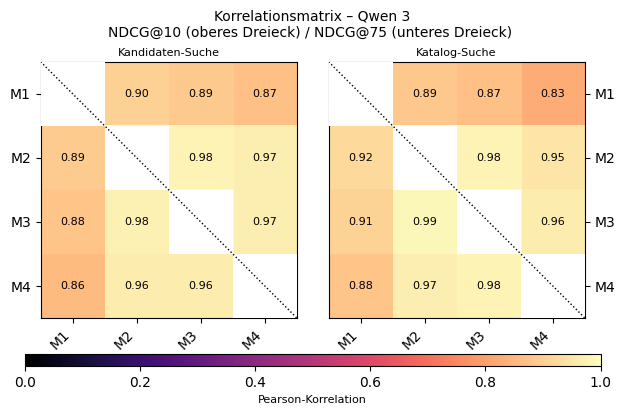

Path will be ../src/code_output/4_metrics_eval/qwen/corr_recall_combined_.pgf


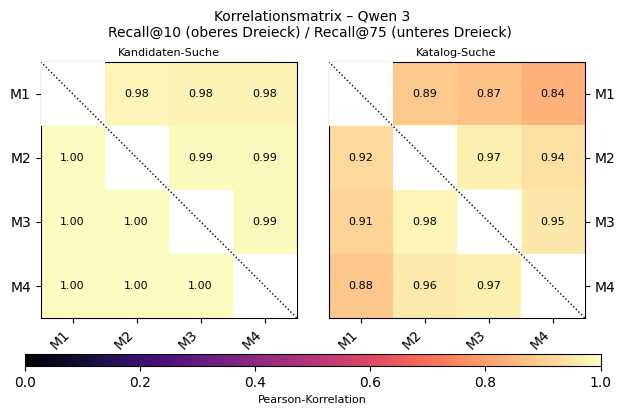

Path will be ../src/code_output/4_metrics_eval/qwen/corr_map_combined_.pgf


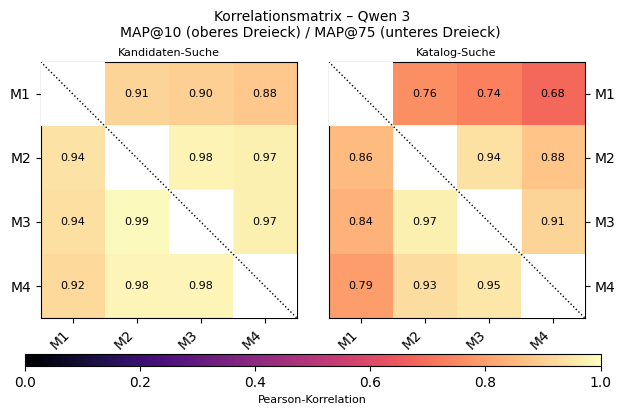

Path will be ../src/code_output/4_metrics_eval/qwen/corr_precision_combined_.pgf


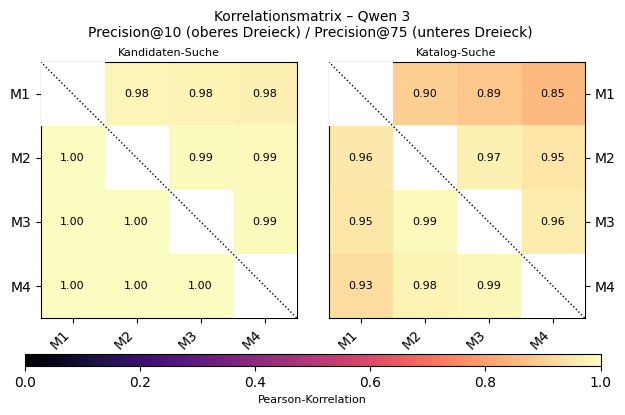

Path will be ../src/code_output/4_metrics_eval/jina_v2/corr_ndcg_combined_.pgf


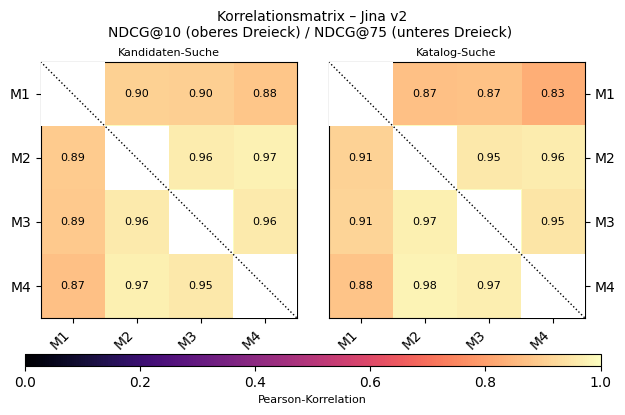

Path will be ../src/code_output/4_metrics_eval/jina_v2/corr_recall_combined_.pgf


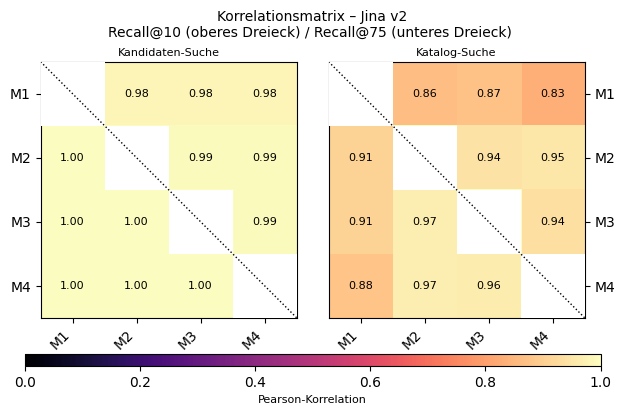

Path will be ../src/code_output/4_metrics_eval/jina_v2/corr_map_combined_.pgf


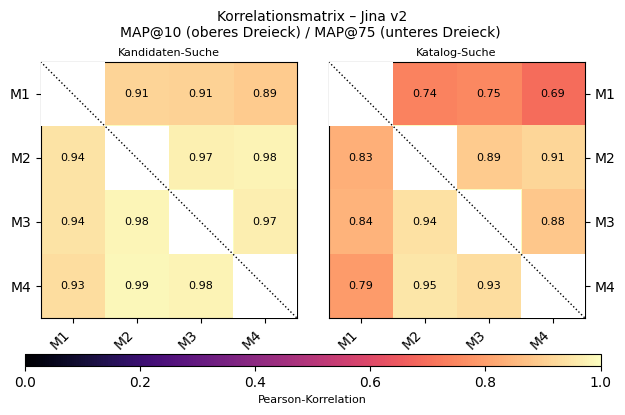

Path will be ../src/code_output/4_metrics_eval/jina_v2/corr_precision_combined_.pgf


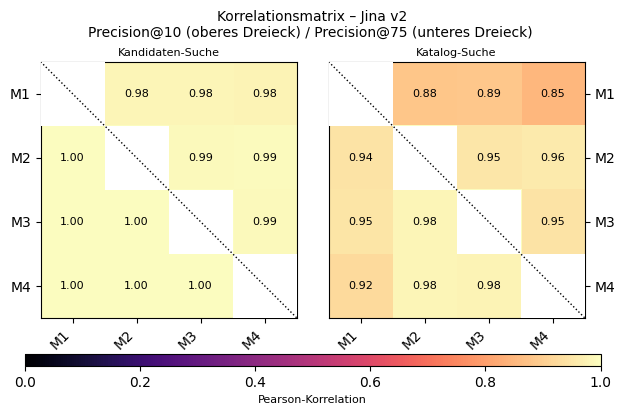

In [9]:
def _build_metric_corr_matrix(
    method_dfs: Dict[str, pd.DataFrame],
    col_metric: str,
) -> pd.DataFrame:
    """
    Baut eine Korrelationsmatrix für eine Metrik über alle Methoden und @-Werte.

    Spaltennamen: M<mnum>-<metric>_k  (k = 1, 2, ... für die Reihenfolge in at_values).
    """
    cols: Dict[str, pd.Series] = {}
    for mnum, df in method_dfs.items():
        mnum_label_short = METHODE_NUMBER_TO_LABEL[mnum].split(":")[0]  # z.B. "M1"
        s = df[col_metric].astype(float).reset_index(drop=True)
        cols[mnum_label_short] = s

    mat_df = pd.DataFrame(cols)
    corr = mat_df.corr(method="pearson")
    return corr


def plot_metric_correlation_for_model_combined(
    model_pattern: str,
    model_results: dict[str, dict[str, pd.DataFrame]],
    metric: str,
    at_values: list[int],
) -> None:
    if len(at_values) != 2:
        raise ValueError(
            "at_values muss genau zwei Werte enthalten, z.B. EVALUATION_AT_VALUES."
        )

    at_top, at_bottom = at_values
    model_label = MODEL_PATTERN_TO_LABEL[model_pattern]

    # etwas kompakteres Format + gemeinsame Y-Achse
    fig, axes = plt.subplots(1, 2, figsize=(9, 4.0), sharey=True)

    common_labels: list[str] | None = None
    im = None
    subtitle_size = 8

    for ax_idx, (ax, (scope, method_dfs)) in enumerate(
        zip(axes, model_results.items())
    ):
        corr_top = _build_metric_corr_matrix(
            method_dfs=method_dfs,
            col_metric=f"{metric}@{at_top}",
        )
        corr_bottom = _build_metric_corr_matrix(
            method_dfs=method_dfs,
            col_metric=f"{metric}@{at_bottom}",
        )

        labels = corr_top.index.tolist()
        n = len(labels)
        if common_labels is None:
            common_labels = labels  # für gemeinsame Y-Achse links

        data = np.full_like(corr_top.to_numpy(), np.nan, dtype=float)
        mask_upper = np.triu(np.ones((n, n), dtype=bool), k=1)
        mask_lower = np.tril(np.ones((n, n), dtype=bool), k=-1)

        data[mask_upper] = corr_top.to_numpy()[mask_upper]
        data[mask_lower] = corr_bottom.to_numpy()[mask_lower]
        np.fill_diagonal(data, 1.0)

        im = ax.imshow(data, vmin=0.0, vmax=1.0, aspect="equal", cmap="magma")

        ax.set_xticks(range(n))
        ax.set_xticklabels(labels, rotation=45, ha="right")

        ax.set_yticks(range(n))
        ax.set_yticklabels(labels)

        # links Labels, rechts ohne (weil sharey=True)
        if ax_idx == 0:
            ax.tick_params(
                axis="y", left=True, labelleft=True, right=False, labelright=False
            )
        else:
            ax.tick_params(
                axis="y", left=False, labelleft=False, right=True, labelright=True
            )

        ax.set_title(scope, size=subtitle_size, pad=4)

        # Diagonale weiß + Trennlinie
        for i in range(n):
            rect = plt.Rectangle(
                (i - 0.5, i - 0.5),
                1.0,
                1.0,
                facecolor="white",
                edgecolor="none",
                zorder=3,
            )
            ax.add_patch(rect)
        ax.plot(
            [-0.5, n - 0.5],
            [-0.5, n - 0.5],
            color="black",
            linewidth=1.0,
            linestyle=":",
            zorder=4,
        )

        # Zahlen: oben @top, unten @bottom
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue  # Diagonale: keine Zahl
                if i < j:
                    val = corr_top.iloc[i, j]
                elif i > j:  # unteres Dreieck: @bottom
                    val = corr_bottom.iloc[i, j]
                ax.text(
                    j,
                    i,
                    f"{val:.2f}",
                    ha="center",
                    va="center",
                    fontsize=subtitle_size,
                    color="black",
                    zorder=5,
                )

        ax.grid(False)

    # Suptitle vor Layout-Anpassung
    title_size = 10
    y_space = 0.03
    title = (
        f"Korrelationsmatrix – {model_label}\n"
        f"{metric}@{at_top} (oberes Dreieck) / "
        f"{metric}@{at_bottom} (unteres Dreieck) "
    )
    if not SAVE_PGF:
        fig.suptitle(
            title,
            y=1 - y_space,
            fontsize=title_size,
        )
    else:
        print(title)

    # Plots näher zusammenrücken und unten Platz schaffen
    fig.subplots_adjust(
        left=0.02,
        right=0.98,
        top=1 - title_size / 100 - 2 * y_space,
        bottom=0.20,
        wspace=-0.50,
    )

    # horizontale Colorbar zentriert unter beiden Plots, etwas näher dran
    cax = fig.add_axes((0.18, 0.08, 0.64, 0.03))  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_label("Pearson-Korrelation", fontsize=subtitle_size)
    out = get_path(model_pattern, f"corr_{metric}_combined_.pgf")
    show_or_safe_fig(out, fig)


for model_pattern, model_results in raw_results.items():
    for metric in EVALUATION_METRICS:
        plot_metric_correlation_for_model_combined(
            model_pattern=model_pattern,
            model_results=model_results,
            metric=metric,
            at_values=EVALUATION_AT_VALUES,
        )